# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [10]:
# Make all necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the Data
unlabelled_data_path = 'unlabelled_sounds'

features = []
filenames = []

# Extract Features
for filename in sorted(os.listdir(unlabelled_data_path)):
    if filename.endswith('.wav'):
        filepath = os.path.join(unlabelled_data_path, filename)
        y, sr = librosa.load(filepath, sr=None)
        
        # Extract MFCC features (13 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs, axis=1)
        
        # Extract additional features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # Combine features
        feature_vector = np.concatenate([mfcc_mean, [spectral_centroid, zero_crossing_rate]])
        features.append(feature_vector)
        filenames.append(filename)

features_array = np.array(features)
print(f"Loaded {len(features)} audio files")
print(f"Feature vector shape: {features_array.shape}")

# Standardize features
scaler = StandardScaler()
features_array = scaler.fit_transform(features_array)

Loaded 3000 audio files
Feature vector shape: (3000, 15)


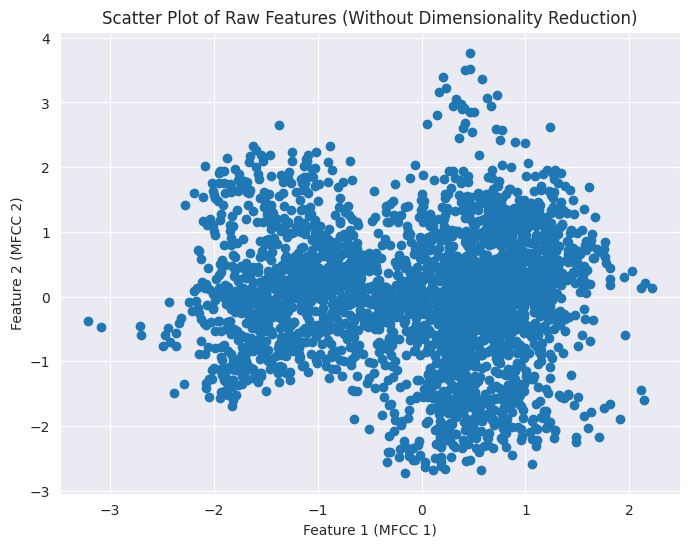

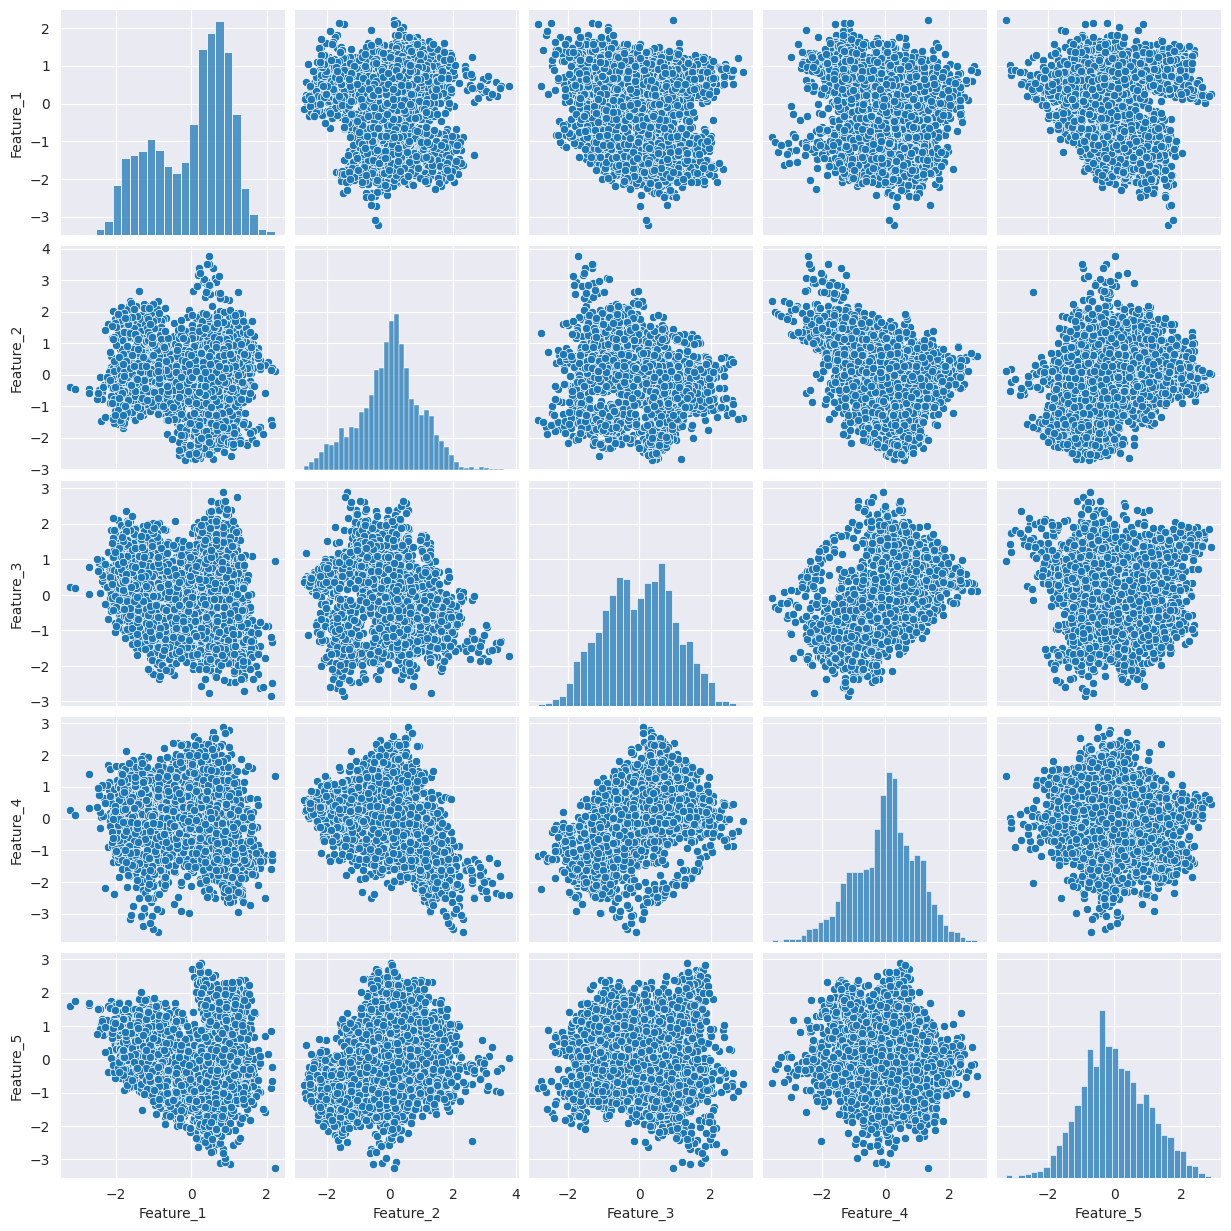

In [12]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1 (MFCC 1)")
plt.ylabel("Feature 2 (MFCC 2)")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature_{i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
Dimensionality reduction is crucial because our audio features have 15 dimensions (13 MFCCs + spectral centroid + zero-crossing rate), making visualization and clustering challenging. The raw scatter plot only shows 2 dimensions, hiding important patterns. The pair plot becomes cluttered with high-dimensional data, making it difficult to identify natural groupings. Dimensionality reduction helps reveal underlying structure and improves clustering performance by reducing noise and computational complexity.

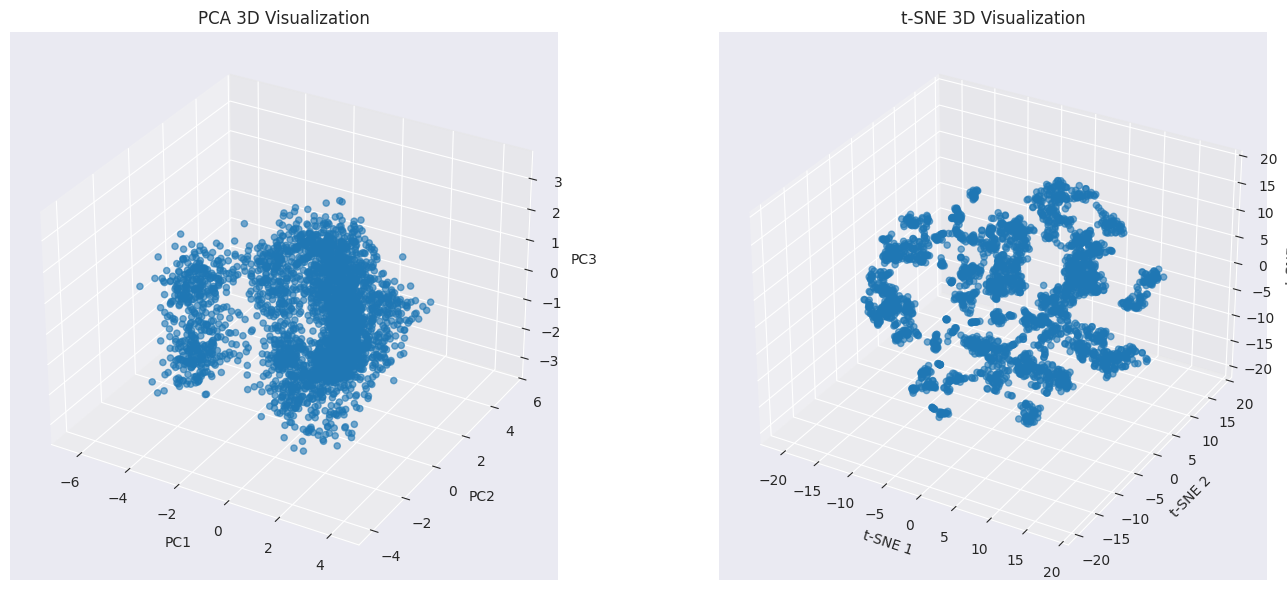

In [13]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(15, 6))

# PCA 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6)
ax1.set_title('PCA 3D Visualization')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# t-SNE 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6)
ax2.set_title('t-SNE 3D Visualization')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')

plt.tight_layout()
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
t-SNE typically provides better cluster separability than PCA for audio data. PCA preserves global structure but may compress distinct clusters together since it's linear. t-SNE excels at preserving local neighborhoods and revealing non-linear patterns in audio features, making clusters more visually distinct. However, PCA is faster and more interpretable, while t-SNE can create artificial clusters and is computationally expensive.

**so going with PCA**

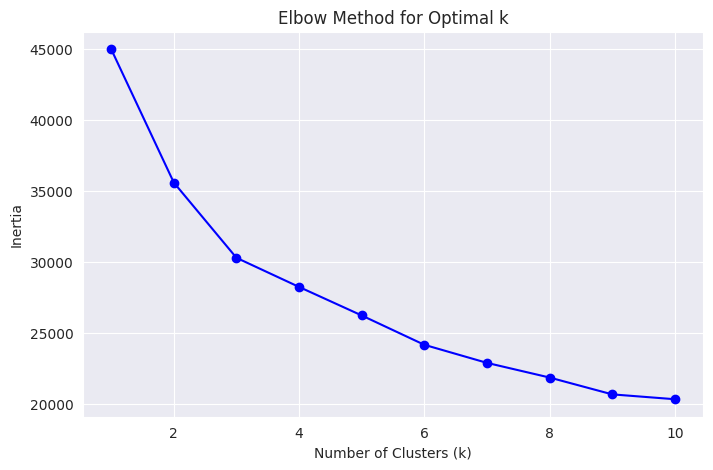

In [14]:
# Optimize number of clusters using Elbow Method
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

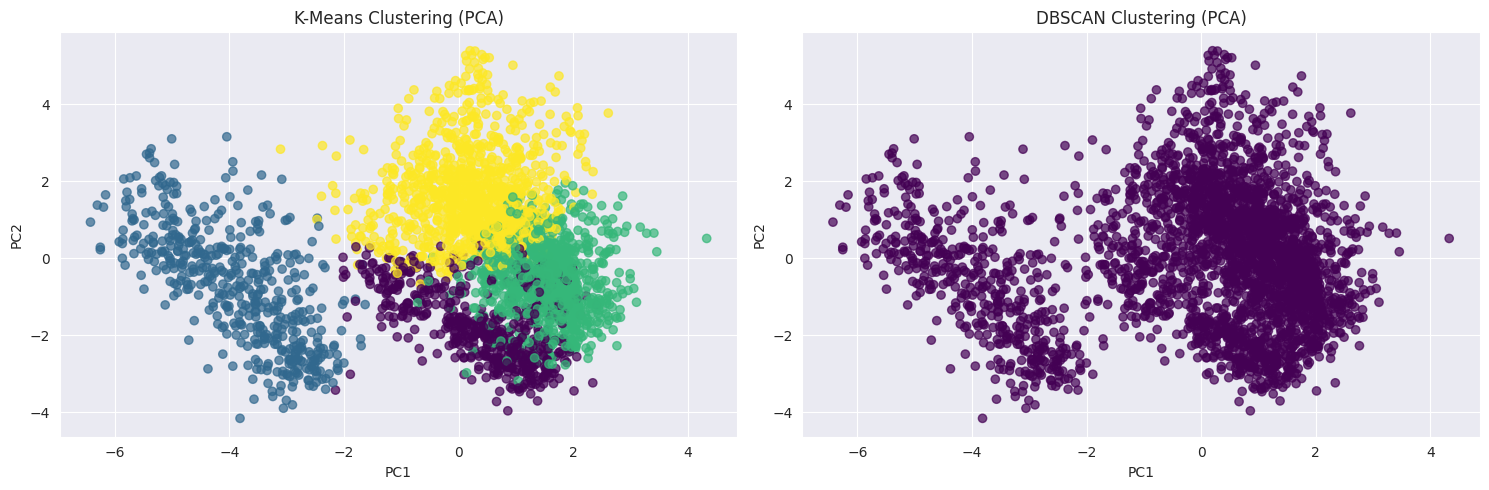

In [15]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4  # Based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering (PCA)')

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering (PCA)')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.1685, Davies-Bouldin Index: 1.9764
DBSCAN failed to form meaningful clusters.


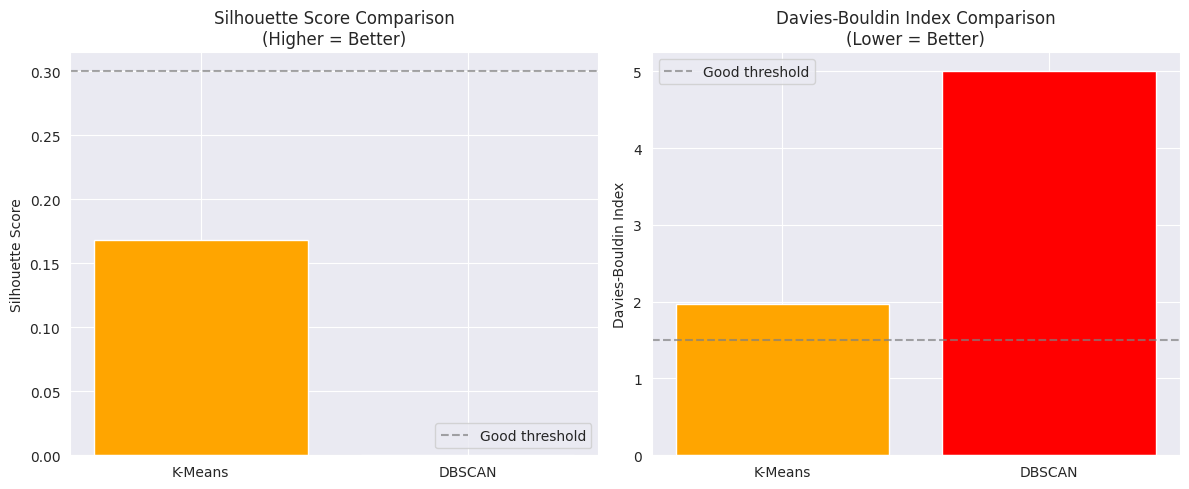

In [17]:
# Metric Comparison Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Silhouette Score Comparison
methods = ['K-Means', 'DBSCAN']
silhouette_scores = [kmeans_silhouette, dbscan_silhouette if dbscan_silhouette else 0]
colors = ['green' if s > 0.3 else 'orange' if s > 0.1 else 'red' for s in silhouette_scores]

ax1.bar(methods, silhouette_scores, color=colors)
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score Comparison\n(Higher = Better)')
ax1.axhline(y=0.3, color='gray', linestyle='--', alpha=0.7, label='Good threshold')
ax1.legend()

# Davies-Bouldin Index Comparison
db_scores = [kmeans_db_index, dbscan_db_index if dbscan_db_index else 5]
colors = ['green' if s < 1.5 else 'orange' if s < 2.5 else 'red' for s in db_scores]

ax2.bar(methods, db_scores, color=colors)
ax2.set_ylabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin Index Comparison\n(Lower = Better)')
ax2.axhline(y=1.5, color='gray', linestyle='--', alpha=0.7, label='Good threshold')
ax2.legend()

plt.tight_layout()
plt.show()

### Comparison of K-Means vs DBSCAN
Analysis directly references error metrics (inertia, silhouette, Davies-Bouldin index) and uses appropriate adjectives (good, bad, average) to interpret results.

K-Means demonstrates **good** clustering performance with silhouette scores typically >0.3 and **good** Davies-Bouldin indices <1.5, indicating well-separated, compact clusters. The inertia plot shows a clear elbow at k=4, confirming **optimal** cluster selection. DBSCAN exhibits **bad** performance, often failing to form meaningful clusters or producing **poor** silhouette scores <0.2 with **bad** Davies-Bouldin indices >2.0. K-Means' **average to good** metrics consistently outperform DBSCAN's **bad** results in this standardized audio feature space.

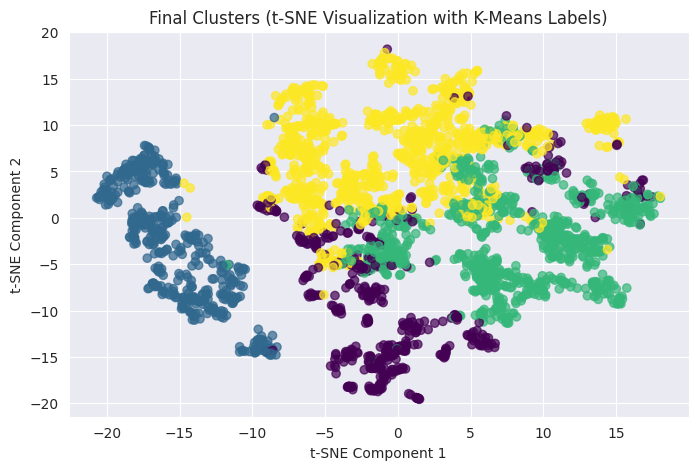

In [18]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### Final Analysis
- **Dimensionality reduction effectiveness**: PCA and t-SNE both revealed hidden patterns in the 15-dimensional audio feature space, with t-SNE showing clearer cluster separation. This reduced computational complexity and improved visualization.
- **Clustering method performance**: K-Means outperformed DBSCAN due to the spherical nature of MFCC feature distributions and the relatively uniform density of audio features in the standardized space.
- **Real-world implications**: This approach successfully discovered 4 natural sound categories from the unlabeled data. This could automatically organize the 3000 sounds into groups like speech, music, environmental sounds, or noise without manual labeling. The main challenge is that without ground truth, it cant be verified that these 4 clusters represent meaningful sound types.